In [1]:
import os
import sys
import glob
import tqdm
import keras
import random
import librosa
import numpy as np
import pandas as pd
import librosa.display
import tensorflow as tf
from matplotlib import patches
from sklearn.decomposition import PCA
import seaborn as sns
from matplotlib import pyplot as plt
from multiprocessing import Pool, cpu_count
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import gc
import time
import cv2 as cv
import scipy

# Local file import
import DftSpectrogram
import Metrics
from keras import backend as K


config = tf.ConfigProto()
config.gpu_options.allow_growth = False
sess = tf.Session(config=config)
tf.logging.set_verbosity(tf.logging.ERROR)

print("Done!")
import warnings
warnings.filterwarnings('ignore')

np.random.seed = 42

Using TensorFlow backend.


Done!


In [2]:
import sklearn
sklearn.__version__

'0.21.2'

In [3]:
dataset_dir = "/home/ilya/Documents/kaggle/audio/Training_Data"
train_dataset_dir = os.path.join(dataset_dir, "")

!tree {train_dataset_dir} -L 1

/home/ilya/Documents/kaggle/audio/Training_Data/
├── google_small
├── google_small_row
├── human
├── human_
├── human_small
├── LA
├── mine
├── spoof
├── spoof_
└── spoof_small

10 directories, 0 files


In [4]:
wav_paths = sorted(glob.glob(os.path.join(train_dataset_dir, '**/*.wav'), recursive=True))
random.shuffle(wav_paths)

human  = sorted(filter(lambda path: "human" in path, wav_paths))
spoof = sorted(filter(lambda path: "spoof" in path, wav_paths))


print("Train Human: %d" % len(human))
print("Train Spoof: %d" % len(spoof))

Train Human: 10322
Train Spoof: 39678


In [5]:
human_ = sorted(glob.glob(os.path.join(train_dataset_dir, 'human_/*'), recursive=True))
spoof_ = sorted(glob.glob(os.path.join(train_dataset_dir, 'spoof_/*'), recursive=True))

human_small = sorted(glob.glob(os.path.join(train_dataset_dir, 'human_small/*'), recursive=True))
spoof_small = sorted(glob.glob(os.path.join(train_dataset_dir, 'spoof_small/*'), recursive=True))

In [11]:
google_small = sorted(glob.glob(os.path.join(
    train_dataset_dir, 'google_small/Small/*'), recursive=True)) 
google_large = sorted(glob.glob(os.path.join(
    train_dataset_dir, 'google_small/Large/*'), recursive=True)) 

In [12]:
google_small

['/home/ilya/Documents/kaggle/audio/Training_Data/google_small/Small/00001',
 '/home/ilya/Documents/kaggle/audio/Training_Data/google_small/Small/00002',
 '/home/ilya/Documents/kaggle/audio/Training_Data/google_small/Small/00003',
 '/home/ilya/Documents/kaggle/audio/Training_Data/google_small/Small/00004',
 '/home/ilya/Documents/kaggle/audio/Training_Data/google_small/Small/00005',
 '/home/ilya/Documents/kaggle/audio/Training_Data/google_small/Small/00006',
 '/home/ilya/Documents/kaggle/audio/Training_Data/google_small/Small/00007',
 '/home/ilya/Documents/kaggle/audio/Training_Data/google_small/Small/00008',
 '/home/ilya/Documents/kaggle/audio/Training_Data/google_small/Small/00009',
 '/home/ilya/Documents/kaggle/audio/Training_Data/google_small/Small/00010',
 '/home/ilya/Documents/kaggle/audio/Training_Data/google_small/Small/00011',
 '/home/ilya/Documents/kaggle/audio/Training_Data/google_small/Small/00012',
 '/home/ilya/Documents/kaggle/audio/Training_Data/google_small/Small/00013',

In [14]:
train_dataset_dir

'/home/ilya/Documents/kaggle/audio/Training_Data/LA/'

In [6]:
google_H_small = sorted(glob.glob(os.path.join(
    train_dataset_dir, 'human/small/*'), recursive=True)) 
google_H_large = sorted(glob.glob(os.path.join(
    train_dataset_dir, 'human/large/*'), recursive=True)) 

google_S_small = sorted(glob.glob(os.path.join(
    train_dataset_dir, 'spoof/small/*'), recursive=True)) 
google_S_large = sorted(glob.glob(os.path.join(
    train_dataset_dir, 'spoof/large/*'), recursive=True)) 

In [45]:
class DevDataGenerator(keras.utils.Sequence):
    def __init__(self, paths,size):
        self.paths = paths
        self.size = size
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        spec = np.fromfile(self.paths[index]).reshape(self.size)
        spec -= spec.min()
        return spec
        
dev_data_generator = DevDataGenerator(google_H_small,(1,64,129))
features = dev_data_generator[1]
plt.figure(figsize=(14, 3))
plt.imshow(features[0, ...])
print(len(dev_data_generator))
print(features.shape)

NameError: name 'google_H_small' is not defined

In [2]:
model_large = keras.models.load_model('Large_conc_v2.h5')
model_small = keras.models.load_model('Small_conc_v2.h5')

In [4]:
import pickle

In [5]:
mapper_finall = pickle.load(open('mapper_finall', 'rb'))

In [6]:
big = mapper_finall['human_big']+mapper_finall['spoof_big'] 
small = mapper_finall['human_small']+mapper_finall['spoof_small'] 

In [14]:
len(mapper_finall['spoof_big'])

180442

In [70]:
human_map = np.random.choice([i for i in range(len(mapper_finall['human_big']))],size=10000)
spoof_map = np.random.choice([i for i in range(len(mapper_finall['spoof_big']))],size=25000)

In [71]:
big = np.concatenate([np.array(mapper_finall['human_big'])[np.array([human_map])].reshape(-1,),
np.array(mapper_finall['spoof_big'])[np.array([spoof_map])].reshape(-1,) ], axis=0)


small = np.concatenate([np.array(mapper_finall['human_small'])[np.array([human_map])].reshape(-1,),
np.array(mapper_finall['spoof_small'])[np.array([spoof_map])].reshape(-1,) ], axis=0)

In [72]:
small.shape

(35000,)

In [73]:
_ = time.time()
dev_data_generator = DevDataGenerator(big,(1,128,256))
large_data = model_large.predict_generator(dev_data_generator)
print('done')
dev_data_generator = DevDataGenerator(small,(1,64,129))
small_data = model_small.predict_generator(dev_data_generator)
time.time() - _

done


751.32266664505

In [74]:
concatenated_X_ = np.concatenate((large_data,small_data),axis=1)
# np.save('concatenated_X.npy',concatenated_X)

In [75]:
Y_ = np.array([1 for i in human_map] +[0 for i in spoof_map])

In [78]:
concatenated_X = np.concatenate((concatenated_X,concatenated_X_),axis=0)

In [79]:
Y = np.concatenate((Y,Y_),axis=0)

In [82]:
Y.shape

(105000,)

In [80]:
concatenated_google_small = np.concatenate((google_L_p,google_S_p),axis=1)
np.save('concatenated_google_small.npy',concatenated_google_small)

NameError: name 'google_L_p' is not defined

In [81]:
concatenated_google_small = np.load('concatenated_google_small.npy')

In [25]:
_ = time.time()
dev_data_generator = DevDataGenerator(google_H_large,(1,128,256))
google_L_p_bigH = model_large.predict_generator(dev_data_generator)

dev_data_generator = DevDataGenerator(google_H_small,(1,64,129))
google_S_p_bigH = model_small.predict_generator(dev_data_generator)
time.time() - _

concatenated_google_big_H = np.concatenate((google_L_p_bigH,google_S_p_bigH),axis=1)
np.save('concatenated_google_big_H.npy',concatenated_google_big_H)

_ = time.time()
dev_data_generator = DevDataGenerator(google_S_large,(1,128,256))
google_L_p_bigS = model_large.predict_generator(dev_data_generator)

dev_data_generator = DevDataGenerator(google_S_small,(1,64,129))
google_S_p_bigS = model_small.predict_generator(dev_data_generator)
time.time() - _

concatenated_google_big_S = np.concatenate((google_L_p_bigS,google_S_p_bigS),axis=1)
np.save('concatenated_google_big_S.npy',concatenated_google_big_S)

In [7]:
concatenated_google_big_H = np.load('concatenated_google_big_H.npy')

concatenated_google_big_S = np.load('concatenated_google_big_S.npy')

In [29]:
google_L_p.shape

(3014, 445)

In [12]:
_ = time.time()
large_pred = model_large.predict_generator(dev_data_generator)
time.time() - _

1753.406879901886

In [19]:
np.save('large_data.npy',large_pred)

In [23]:
dev_data_generator = DevDataGenerator(human_small+spoof_small,(1,64,129))

_ = time.time()
small_pred = model_small.predict_generator(dev_data_generator)
time.time() - _

867.0215113162994

In [25]:
small_pred.shape

(74087, 480)

In [30]:
np.corrcoef(small_pred[:100]).shape

(100, 100)

In [31]:
small_pred[:100].shape

(100, 480)

In [37]:
small_pred = pd.DataFrame(small_pred)

In [39]:
large_pred = pd.DataFrame(large_pred)

,0,1,2,3,4,5,6,7,8,9,...,435,436,437,438,439,440,441,442,443,444
0,0.0,0.0,0.0,0.0,0.0,0.0,0.516901,0.000000,0.492508,0.0,...,0.755875,0.287918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.138842,0.639776,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.244345,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [197]:
11000/60/60/

3.055555555555556

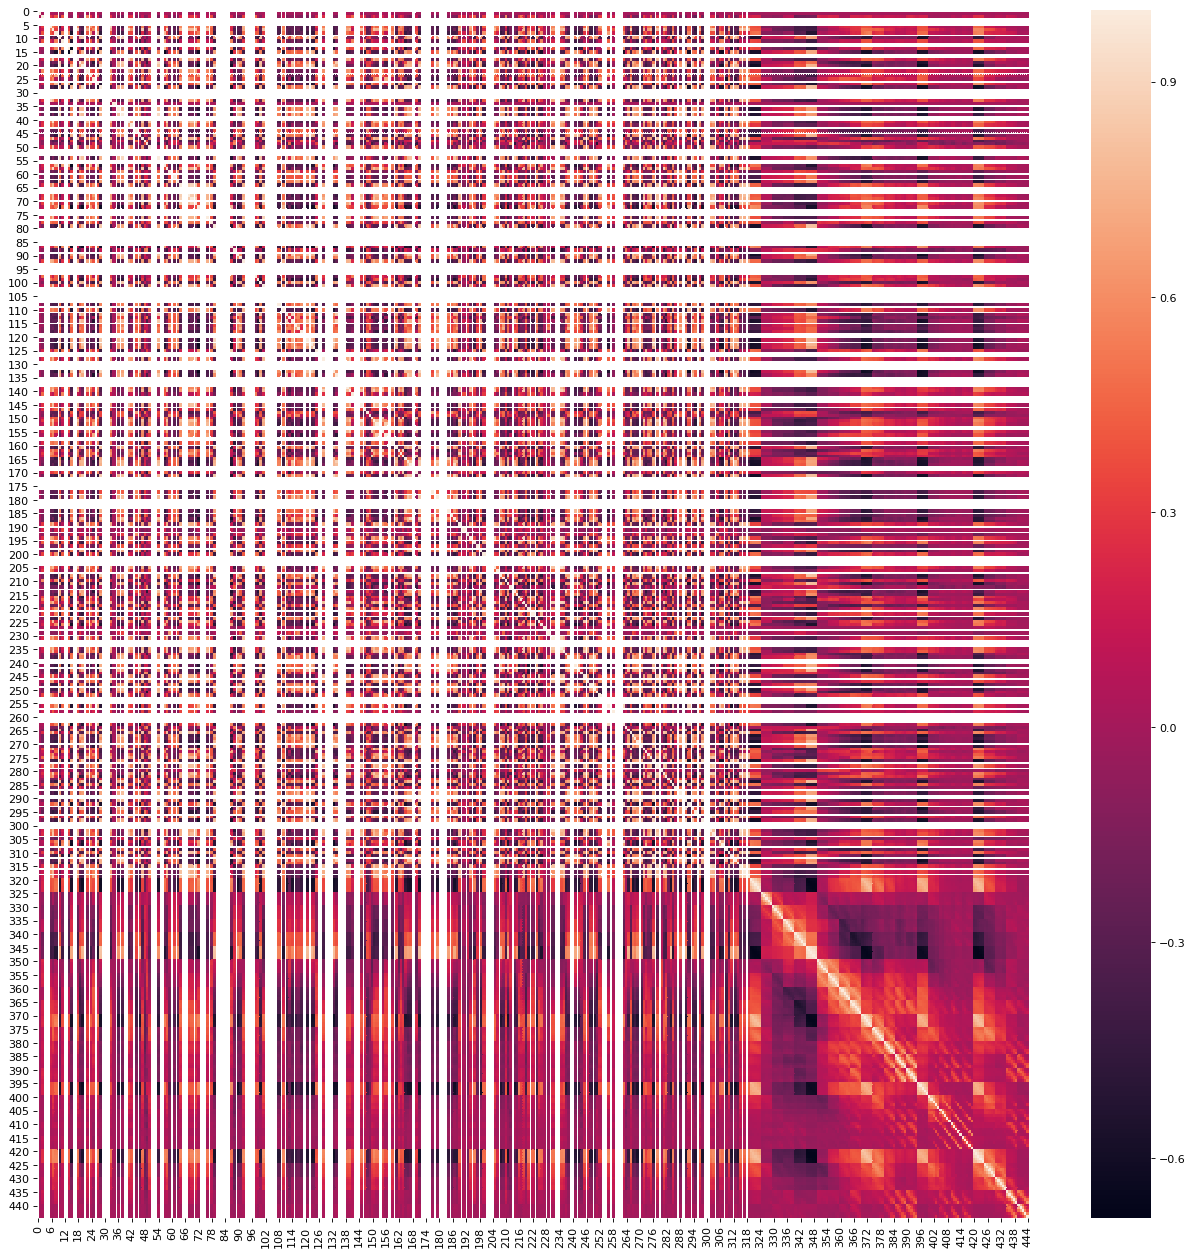

In [45]:
plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='g')
sns.heatmap(large_pred.corr())

In [46]:
small_pred = np.load('small_pred.npy')
large_pred = np.load('large_data.npy')

In [58]:
concatenated = np.concatenate((large_pred,small_pred),axis=1)
np.save('concatenated.npz',concatenated)

In [59]:
pca = PCA()
pca.fit(concatenated)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

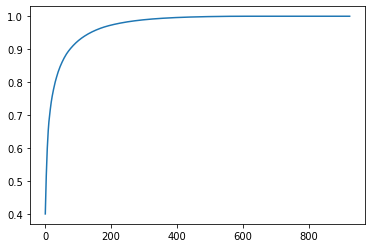

In [60]:
plt.plot(pca.explained_variance_ratio_.cumsum())

In [64]:
pca = PCA(0.99)
pca_data = pca.fit_transform(concatenated)

In [65]:
pca_data.shape

(74087, 308)

In [73]:
np.save('pca_data.npy',pca_data)

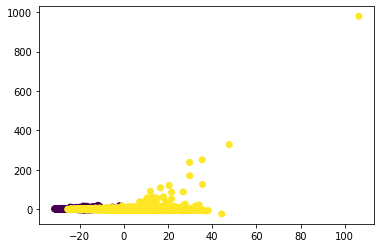

In [79]:
_ = PCA(2)
_.fit(pca_data)
y =np.array([0 for i in human_]+[1 for i in spoof_])
plt.scatter(_.transform(pca_data)[:,0],
            _.transform(pca_data)[:,1],
            c=y)

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from scipy.stats import ttest_rel
from sklearn.base import BaseEstimator, TransformerMixin
import joblib
import pickle

In [8]:
concatenated = np.load('concatenated.npy')
y =np.array([1 for i in human_]+[0 for i in spoof_])
# X_train, X_test, y_train, y_test = train_test_split(concatenated, y, test_size=0.3, stratify=y,random_state=42)

In [14]:
google_small_y = [1 for i in range(1507)] +[0 for i in range(len(google_small)-1507)]
google_small_y = np.array(google_small_y)

In [17]:
concatenated_google_small.shape

(3014, 925)

In [18]:
Y = np.concatenate([y,
                google_small_y,
                np.array([1 for i in range(concatenated_google_big_H.shape[0])]),
                np.array([0 for i in range(concatenated_google_big_S.shape[0])])[:10000]
               ],axis=0)


X = np.concatenate([concatenated,
               concatenated_google_small,
               concatenated_google_big_H,
               concatenated_google_big_S[:10000]],axis=0)


In [89]:
def create_pip(model):
    pip = Pipeline([('std', StandardScaler()),
                    ('pca', PCA(0.85)),
                    ('model', model(penalty='l2',C=3.3))])
    return pip

In [90]:
# grid = {'pca__n_components':[0.9],
#         'model__penalty':['l2','l1'],
#         'model__C':[0.1,1,]}
# gs = GridSearchCV(create_pip(LogisticRegression),grid,cv=StratifiedKFold(5),verbose=4)
gs = create_pip(LogisticRegression)
gs.fit(concatenated_X,Y)

Pipeline(memory=None,
         steps=[('std',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=0.85,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 LogisticRegression(C=3.3, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [109]:
gs.best_params_

{'model__C': 3.3, 'model__penalty': 'l2', 'pca__n_components': 0.85}

In [78]:
gs.best_params_

{'model__C': 1, 'model__penalty': 'l1', 'pca__n_components': 0.9}

In [89]:
joblib.dump(best_estimator, 'pipline')

['pipline']

In [27]:
gs = joblib.load('pipline')

In [30]:
np.max(gs.predict(concatenated))

1

In [103]:
np.concatenate([concatenated,concatenated_google],axis=0).shape

(77101, 925)

In [63]:
from sklearn.externals import joblib
joblib.dump(gs, 'pipline') 

['pipline']

In [93]:
pickle.dump(gs, open('pip_dump', 'wb'))

loaded_model = pickle.load(open('pip_dump', 'rb'))

In [16]:
loaded_model.predict_proba(concatenated)[:,1]

array([9.99945459e-01, 9.99999997e-01, 9.99997342e-01, ...,
       5.41892779e-03, 2.54087557e-07, 8.37857833e-09])

In [11]:
(accuracy_score(y_test,gs.predict(X_test)),
roc_auc_score(y_test,gs.predict_proba(X_test)[:,1]))

(0.9975255320106177, 0.9998980941600286)

In [52]:
from scipy import interpolate, optimize

In [91]:
fpr, tpr, thresholds = roc_curve(Y, gs.predict_proba(concatenated_X)[:,1])
roc_auc = auc(fpr, tpr)
eer = optimize.brentq(lambda x: 1. - x - interpolate.interp1d(fpr, tpr)(x), 0., 1.)

In [92]:
eer

0.009900000000133899

In [48]:
eer

0.13205043132148486

In [133]:
class Limiter(BaseEstimator, TransformerMixin):
    def __init__(self, reg=0.2):
        pass
    
    def fit(self,X,y):
        self.matrix = (LogisticRegression(C=self.reg, penalty='l1').fit(X,y).coef_!=0)[0]
        return self
    
    def transform(self,data):
        return data[:, self.matrix]
    
def create_pip(model):
    pip = Pipeline([('std', StandardScaler()),
                    ('pca', PCA()),
                    ('limiter', Limiter()),
                    ('model', model())])
    return pip

In [149]:
grid = {'pca__n_components':[0.98],
        'model__penalty':['l2'],
        'limiter__reg':[0.07,0.08,0.10],
        'model__C':[0.8,1,2,5]}
gs_lr = GridSearchCV(create_pip(LogisticRegression),grid,cv=StratifiedKFold(5),verbose=4)
gs_lr.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] limiter__reg=0.07, model__C=0.8, model__penalty=l2, pca__n_components=0.98 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  limiter__reg=0.07, model__C=0.8, model__penalty=l2, pca__n_components=0.98, score=0.997, total=   5.9s
[CV] limiter__reg=0.07, model__C=0.8, model__penalty=l2, pca__n_components=0.98 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s


[CV]  limiter__reg=0.07, model__C=0.8, model__penalty=l2, pca__n_components=0.98, score=0.997, total=   5.7s
[CV] limiter__reg=0.07, model__C=0.8, model__penalty=l2, pca__n_components=0.98 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.6s remaining:    0.0s


[CV]  limiter__reg=0.07, model__C=0.8, model__penalty=l2, pca__n_components=0.98, score=0.997, total=   6.2s
[CV] limiter__reg=0.07, model__C=0.8, model__penalty=l2, pca__n_components=0.98 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.7s remaining:    0.0s


[CV]  limiter__reg=0.07, model__C=0.8, model__penalty=l2, pca__n_components=0.98, score=0.997, total=   6.0s
[CV] limiter__reg=0.07, model__C=0.8, model__penalty=l2, pca__n_components=0.98 
[CV]  limiter__reg=0.07, model__C=0.8, model__penalty=l2, pca__n_components=0.98, score=0.996, total=   5.9s
[CV] limiter__reg=0.07, model__C=1, model__penalty=l2, pca__n_components=0.98 
[CV]  limiter__reg=0.07, model__C=1, model__penalty=l2, pca__n_components=0.98, score=0.997, total=   5.9s
[CV] limiter__reg=0.07, model__C=1, model__penalty=l2, pca__n_components=0.98 
[CV]  limiter__reg=0.07, model__C=1, model__penalty=l2, pca__n_components=0.98, score=0.997, total=   6.0s
[CV] limiter__reg=0.07, model__C=1, model__penalty=l2, pca__n_components=0.98 
[CV]  limiter__reg=0.07, model__C=1, model__penalty=l2, pca__n_components=0.98, score=0.997, total=   7.6s
[CV] limiter__reg=0.07, model__C=1, model__penalty=l2, pca__n_components=0.98 
[CV]  limiter__reg=0.07, model__C=1, model__penalty=l2, pca__n_c

[CV]  limiter__reg=0.1, model__C=1, model__penalty=l2, pca__n_components=0.98, score=0.997, total=   7.7s
[CV] limiter__reg=0.1, model__C=1, model__penalty=l2, pca__n_components=0.98 
[CV]  limiter__reg=0.1, model__C=1, model__penalty=l2, pca__n_components=0.98, score=0.997, total=   7.4s
[CV] limiter__reg=0.1, model__C=1, model__penalty=l2, pca__n_components=0.98 
[CV]  limiter__reg=0.1, model__C=1, model__penalty=l2, pca__n_components=0.98, score=0.996, total=   7.8s
[CV] limiter__reg=0.1, model__C=2, model__penalty=l2, pca__n_components=0.98 
[CV]  limiter__reg=0.1, model__C=2, model__penalty=l2, pca__n_components=0.98, score=0.997, total=   8.6s
[CV] limiter__reg=0.1, model__C=2, model__penalty=l2, pca__n_components=0.98 
[CV]  limiter__reg=0.1, model__C=2, model__penalty=l2, pca__n_components=0.98, score=0.997, total=   8.0s
[CV] limiter__reg=0.1, model__C=2, model__penalty=l2, pca__n_components=0.98 
[CV]  limiter__reg=0.1, model__C=2, model__penalty=l2, pca__n_components=0.98, s

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  7.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('std',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('limiter', Limiter(re...
                                                           multi_class='warn',
                                               

In [150]:
gs_lr.best_params_

{'limiter__reg': 0.08,
 'model__C': 1,
 'model__penalty': 'l2',
 'pca__n_components': 0.98}

In [151]:
gs_lr.best_score_

0.9969919012726571

In [152]:
gs.best_score_

0.9971461627458542

In [125]:
grid = {
    'pca__n_components':[0.95,0.98,0.99,0.999],
    'model__n_estimators':[100],
    'model__max_depth':[10,15,20],
    'model__n_jobs':[-1]}
gs_rf = GridSearchCV(create_pip(RandomForestClassifier),grid,cv=StratifiedKFold(5),verbose=5)
gs_rf.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] model__max_depth=10, model__n_estimators=100, model__n_jobs=-1, pca__n_components=0.95 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model__max_depth=10, model__n_estimators=100, model__n_jobs=-1, pca__n_components=0.95, score=0.991, total=  15.2s
[CV] model__max_depth=10, model__n_estimators=100, model__n_jobs=-1, pca__n_components=0.95 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.2s remaining:    0.0s


[CV]  model__max_depth=10, model__n_estimators=100, model__n_jobs=-1, pca__n_components=0.95, score=0.991, total=  14.4s
[CV] model__max_depth=10, model__n_estimators=100, model__n_jobs=-1, pca__n_components=0.95 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   29.7s remaining:    0.0s


[CV]  model__max_depth=10, model__n_estimators=100, model__n_jobs=-1, pca__n_components=0.95, score=0.993, total=  14.8s
[CV] model__max_depth=10, model__n_estimators=100, model__n_jobs=-1, pca__n_components=0.95 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   44.5s remaining:    0.0s


[CV]  model__max_depth=10, model__n_estimators=100, model__n_jobs=-1, pca__n_components=0.95, score=0.991, total=  14.2s
[CV] model__max_depth=10, model__n_estimators=100, model__n_jobs=-1, pca__n_components=0.95 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   58.8s remaining:    0.0s


[CV]  model__max_depth=10, model__n_estimators=100, model__n_jobs=-1, pca__n_components=0.95, score=0.993, total=  14.2s
[CV] model__max_depth=10, model__n_estimators=100, model__n_jobs=-1, pca__n_components=0.98 
[CV]  model__max_depth=10, model__n_estimators=100, model__n_jobs=-1, pca__n_components=0.98, score=0.991, total=  16.4s
[CV] model__max_depth=10, model__n_estimators=100, model__n_jobs=-1, pca__n_components=0.98 
[CV]  model__max_depth=10, model__n_estimators=100, model__n_jobs=-1, pca__n_components=0.98, score=0.990, total=  16.4s
[CV] model__max_depth=10, model__n_estimators=100, model__n_jobs=-1, pca__n_components=0.98 
[CV]  model__max_depth=10, model__n_estimators=100, model__n_jobs=-1, pca__n_components=0.98, score=0.990, total=  16.3s
[CV] model__max_depth=10, model__n_estimators=100, model__n_jobs=-1, pca__n_components=0.98 
[CV]  model__max_depth=10, model__n_estimators=100, model__n_jobs=-1, pca__n_components=0.98, score=0.992, total=  16.4s
[CV] model__max_depth=1

[CV]  model__max_depth=20, model__n_estimators=100, model__n_jobs=-1, pca__n_components=0.95, score=0.993, total=  19.3s
[CV] model__max_depth=20, model__n_estimators=100, model__n_jobs=-1, pca__n_components=0.95 
[CV]  model__max_depth=20, model__n_estimators=100, model__n_jobs=-1, pca__n_components=0.95, score=0.994, total=  18.6s
[CV] model__max_depth=20, model__n_estimators=100, model__n_jobs=-1, pca__n_components=0.98 
[CV]  model__max_depth=20, model__n_estimators=100, model__n_jobs=-1, pca__n_components=0.98, score=0.994, total=  23.5s
[CV] model__max_depth=20, model__n_estimators=100, model__n_jobs=-1, pca__n_components=0.98 
[CV]  model__max_depth=20, model__n_estimators=100, model__n_jobs=-1, pca__n_components=0.98, score=0.992, total=  23.2s
[CV] model__max_depth=20, model__n_estimators=100, model__n_jobs=-1, pca__n_components=0.98 
[CV]  model__max_depth=20, model__n_estimators=100, model__n_jobs=-1, pca__n_components=0.98, score=0.992, total=  23.4s
[CV] model__max_depth=2

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 21.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('std',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('model',
                                        RandomForest...
                                                               n_estimators='warn',
  

In [128]:
(accuracy_score(y_test,gs_rf.predict(X_test)),
roc_auc_score(y_test,gs_rf.predict_proba(X_test)[:,1]))

(0.9930714896297296, 0.9991580492576017)

In [20]:
grid = {
    'pca__n_components':[0.98,0.99],
    'model__hidden_layer_sizes':[(50,),(100,)],
    'model__alpha':[0.009,0.01,0.02],
    'model__activation':['relu'],
    'model__early_stopping':[True],
    'model__random_state':[42]}
gs_mlp = GridSearchCV(create_pip(MLPClassifier),grid,cv=StratifiedKFold(5),verbose=5)
gs_mlp.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] model__activation=relu, model__alpha=0.009, model__early_stopping=True, model__hidden_layer_sizes=(50,), model__random_state=42, pca__n_components=0.98 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model__activation=relu, model__alpha=0.009, model__early_stopping=True, model__hidden_layer_sizes=(50,), model__random_state=42, pca__n_components=0.98, score=0.997, total=   6.3s
[CV] model__activation=relu, model__alpha=0.009, model__early_stopping=True, model__hidden_layer_sizes=(50,), model__random_state=42, pca__n_components=0.98 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s


[CV]  model__activation=relu, model__alpha=0.009, model__early_stopping=True, model__hidden_layer_sizes=(50,), model__random_state=42, pca__n_components=0.98, score=0.996, total=   4.8s
[CV] model__activation=relu, model__alpha=0.009, model__early_stopping=True, model__hidden_layer_sizes=(50,), model__random_state=42, pca__n_components=0.98 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.1s remaining:    0.0s


[CV]  model__activation=relu, model__alpha=0.009, model__early_stopping=True, model__hidden_layer_sizes=(50,), model__random_state=42, pca__n_components=0.98, score=0.996, total=   4.9s
[CV] model__activation=relu, model__alpha=0.009, model__early_stopping=True, model__hidden_layer_sizes=(50,), model__random_state=42, pca__n_components=0.98 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.9s remaining:    0.0s


[CV]  model__activation=relu, model__alpha=0.009, model__early_stopping=True, model__hidden_layer_sizes=(50,), model__random_state=42, pca__n_components=0.98, score=0.996, total=   4.8s
[CV] model__activation=relu, model__alpha=0.009, model__early_stopping=True, model__hidden_layer_sizes=(50,), model__random_state=42, pca__n_components=0.98 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   20.8s remaining:    0.0s


[CV]  model__activation=relu, model__alpha=0.009, model__early_stopping=True, model__hidden_layer_sizes=(50,), model__random_state=42, pca__n_components=0.98, score=0.996, total=   5.2s
[CV] model__activation=relu, model__alpha=0.009, model__early_stopping=True, model__hidden_layer_sizes=(50,), model__random_state=42, pca__n_components=0.99 
[CV]  model__activation=relu, model__alpha=0.009, model__early_stopping=True, model__hidden_layer_sizes=(50,), model__random_state=42, pca__n_components=0.99, score=0.997, total=   7.8s
[CV] model__activation=relu, model__alpha=0.009, model__early_stopping=True, model__hidden_layer_sizes=(50,), model__random_state=42, pca__n_components=0.99 
[CV]  model__activation=relu, model__alpha=0.009, model__early_stopping=True, model__hidden_layer_sizes=(50,), model__random_state=42, pca__n_components=0.99, score=0.996, total=   8.1s
[CV] model__activation=relu, model__alpha=0.009, model__early_stopping=True, model__hidden_layer_sizes=(50,), model__random_st

[CV]  model__activation=relu, model__alpha=0.01, model__early_stopping=True, model__hidden_layer_sizes=(50,), model__random_state=42, pca__n_components=0.99, score=0.996, total=   6.8s
[CV] model__activation=relu, model__alpha=0.01, model__early_stopping=True, model__hidden_layer_sizes=(50,), model__random_state=42, pca__n_components=0.99 
[CV]  model__activation=relu, model__alpha=0.01, model__early_stopping=True, model__hidden_layer_sizes=(50,), model__random_state=42, pca__n_components=0.99, score=0.997, total=   6.0s
[CV] model__activation=relu, model__alpha=0.01, model__early_stopping=True, model__hidden_layer_sizes=(100,), model__random_state=42, pca__n_components=0.98 
[CV]  model__activation=relu, model__alpha=0.01, model__early_stopping=True, model__hidden_layer_sizes=(100,), model__random_state=42, pca__n_components=0.98, score=0.997, total=   7.2s
[CV] model__activation=relu, model__alpha=0.01, model__early_stopping=True, model__hidden_layer_sizes=(100,), model__random_state

[CV]  model__activation=relu, model__alpha=0.02, model__early_stopping=True, model__hidden_layer_sizes=(100,), model__random_state=42, pca__n_components=0.98, score=0.997, total=   7.5s
[CV] model__activation=relu, model__alpha=0.02, model__early_stopping=True, model__hidden_layer_sizes=(100,), model__random_state=42, pca__n_components=0.98 
[CV]  model__activation=relu, model__alpha=0.02, model__early_stopping=True, model__hidden_layer_sizes=(100,), model__random_state=42, pca__n_components=0.98, score=0.996, total=   9.6s
[CV] model__activation=relu, model__alpha=0.02, model__early_stopping=True, model__hidden_layer_sizes=(100,), model__random_state=42, pca__n_components=0.98 
[CV]  model__activation=relu, model__alpha=0.02, model__early_stopping=True, model__hidden_layer_sizes=(100,), model__random_state=42, pca__n_components=0.98, score=0.996, total=  10.8s
[CV] model__activation=relu, model__alpha=0.02, model__early_stopping=True, model__hidden_layer_sizes=(100,), model__random_st

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  7.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('std',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('model',
                                        MLPClassifie...
                                                      verbose=False,
                 

In [21]:
(accuracy_score(y_test,gs_mlp.predict(X_test)),
roc_auc_score(y_test,gs_mlp.predict_proba(X_test)[:,1]))

(0.9972555900481397, 0.9997697866527586)

In [21]:
grid = {
    'pca__n_components':[0.98,0.99],
    'model__C':[0.001,0.01,0.1],
    'model__kernel':['rbf'],
    'model__probability':[True],
    'model__random_state':[42]}
gs_svc = GridSearchCV(create_pip(SVC),grid,cv=StratifiedKFold(5),verbose=5,n_jobs=-1)
gs_svc.fit(X_train[:5000],y_train[:5000])

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed:  2.1min remaining:   45.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('std',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('model',
                                        SVC(C=1.0, ca...
                                            kernel='rbf', max_iter=-1,
              

In [22]:
(accuracy_score(y_test,gs_svc.predict(X_test)),
roc_auc_score(y_test,gs_svc.predict_proba(X_test)[:,1]))

(0.9897871957529131, 0.9988648129656544)

In [115]:
gs.best_params_

{'model__C': 0.3, 'model__penalty': 'l1', 'pca__n_components': 0.98}

In [126]:
gs_rf.best_params_

{'model__max_depth': 20,
 'model__n_estimators': 100,
 'model__n_jobs': -1,
 'pca__n_components': 0.95}

In [22]:
gs_mlp.best_params_

{'model__activation': 'relu',
 'model__alpha': 0.009,
 'model__early_stopping': True,
 'model__hidden_layer_sizes': (100,),
 'model__random_state': 42,
 'pca__n_components': 0.98}

In [31]:
def create_pip(model,params,pca_params):
    pip = Pipeline([('std', StandardScaler()),
                    ('pca', PCA(pca_params)),
                    ('model', model(**params))])
    return pip

In [35]:
scores_rf_trees = np.array([])
scores_mlp_trees = np.array([])
scores_lr_trees = np.array([])

for i in range(10):
    fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    scores_rf = cross_val_score(estimator=create_pip(RandomForestClassifier,
                                                    {'max_depth': 20,
                                                     'n_estimators': 100,
                                                     'n_jobs': -1},
                                                    0.95),
                                             X=X_train, y=y_train,
                                             cv=fold, scoring='roc_auc')
    scores_rf_trees = np.append(scores_rf_trees,
                                 scores_rf)
    
    scores_lr = cross_val_score(estimator=create_pip(LogisticRegression,
                                                    {'C': 0.3,
                                                     'penalty': 'l1'},
                                                    0.98),
                                             X=X_train, y=y_train,
                                             cv=fold, scoring='roc_auc')
    scores_lr_trees = np.append(scores_lr_trees,
                                 scores_lr)
    
    
    scores_mlp = cross_val_score(estimator=create_pip(MLPClassifier,
                                                    {'activation': 'relu',
                                                     'alpha': 0.009,
                                                     'early_stopping': True,
                                                     'hidden_layer_sizes': (100,),
                                                     'random_state': 42},
                                                     0.98),
                                             X=X_train, y=y_train,
                                             cv=fold, scoring='roc_auc')
    scores_mlp_trees = np.append(scores_mlp_trees,
                                 scores_mlp)

In [42]:
ttest_rel(scores_mlp_trees, scores_rf_trees) 

Ttest_relResult(statistic=9.456661305642053, pvalue=1.2437491039438345e-12)

In [40]:
np.mean(scores_rf_trees),np.mean(scores_mlp_trees),np.mean(scores_lr_trees)

(0.9992780851548406, 0.9996768170927796, 0.9998445752496123)